In [1]:
# ==============================================================
# MSc Project – Biometric Security Baseline + Adversarial Testing
# Author: Stella Williams
# ==============================================================

import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random, io, cv2
from PIL import Image
from tqdm import tqdm

# --------------------------------------------------------------
# Step 1: Initialise model and device
# --------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = InceptionResnetV1(pretrained="vggface2").eval().to(device)

criterion = nn.CosineEmbeddingLoss()
cos = nn.CosineSimilarity(dim=1)


Using: cpu


In [2]:
# --------------------------------------------------------------
# Step 2: Load dataset (LFW) — sample 5 identities for SME realism
# --------------------------------------------------------------
lfw_path = "/Users/stel/Documents/Dissertation/msc-biometric-security/Datasets/lfw-dataset"

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

lfw_full = datasets.ImageFolder(root=lfw_path, transform=transform)

target_classes = random.sample(lfw_full.classes, 5)
print("Selected identities:", target_classes)

target_idx = [i for i, (_, label) in enumerate(lfw_full) 
              if lfw_full.classes[label] in target_classes]

lfw_subset = Subset(lfw_full, target_idx)
lfw_loader = DataLoader(lfw_subset, batch_size=1, shuffle=True)

Selected identities: ['Susie_Castillo', 'Barry_Bonds', 'Gregg_Berhalter', 'Mary_Lou_Retton', 'Natasha_Lyonne']


In [3]:
# --------------------------------------------------------------
# Step 3: FGSM attack function
# --------------------------------------------------------------
def fgsm_attack(image, grad, eps):
    return torch.clamp(image + eps * grad.sign(), 0, 1)

In [4]:
# --------------------------------------------------------------
# Step 4: JPEG defence function
# --------------------------------------------------------------
def jpeg_defence(img_tensor, quality=50):
    img_np = (img_tensor.detach().squeeze()
               .permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    
    _, enc = cv2.imencode(".jpg", img_np, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    dec = cv2.imdecode(enc, cv2.IMREAD_COLOR)

    rec = transforms.ToTensor()(Image.fromarray(cv2.cvtColor(dec, cv2.COLOR_BGR2RGB)))
    return rec.unsqueeze(0).to(device)

In [5]:
# --------------------------------------------------------------
# Step ...: Additional Defence – Gaussian Blur
# --------------------------------------------------------------
def blur_defence(img_tensor, kernel_size=5):
    img_np = (img_tensor.detach().squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(img_np, (kernel_size, kernel_size), 0)
    rec = transforms.ToTensor()(Image.fromarray(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)))
    return rec.unsqueeze(0).to(device)


In [6]:
# --------------------------------------------------------------
# Step 5: Run FGSM once for demonstration
# --------------------------------------------------------------
img, lbl = next(iter(lfw_loader))
img = img.to(device); img.requires_grad = True

embed_orig = model(img)
loss = criterion(embed_orig, embed_orig.detach(), torch.tensor([1.0]).to(device))
model.zero_grad(); loss.backward()

adv = fgsm_attack(img, img.grad.data, eps=0.05)
embed_adv = model(adv)

print("Single FGSM example cosine sim:", cos(embed_orig, embed_adv).item())

jpeg_adv = jpeg_defence(adv)
print("After JPEG defence cosine sim:", cos(embed_orig, model(jpeg_adv)).item())

Single FGSM example cosine sim: 1.0000001192092896
After JPEG defence cosine sim: 0.901986837387085


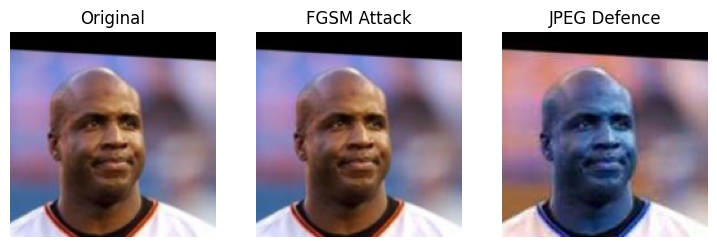

In [7]:
# --------------------------------------------------------------
# Step 6: Visual comparison
# --------------------------------------------------------------
def show(img):
    plt.imshow(img.squeeze().detach().permute(1,2,0).cpu())
    plt.axis("off")

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); show(img); plt.title("Original")
plt.subplot(1,3,2); show(adv); plt.title("FGSM Attack")
plt.subplot(1,3,3); show(jpeg_adv); plt.title("JPEG Defence")
plt.show()

In [8]:
# --------------------------------------------------------------
# Step 7: FGSM benchmark across epsilons
# --------------------------------------------------------------
epsilons = [0.05, 0.10, 0.15, 0.30]
print("\nFGSM benchmark across epsilon values")

for eps in epsilons:
    attack = 0; recover = 0; total = 0
    
    for _ in range(30):
        img, lbl = next(iter(lfw_loader))
        img = img.to(device); img.requires_grad = True
        
        base = model(img)
        loss = criterion(base, base.detach(), torch.tensor([1.0]).to(device))
        model.zero_grad(); loss.backward()
        
        adv = fgsm_attack(img, img.grad.data, eps)
        simA = cos(base, model(adv)).item()
        if simA < 0.8: attack += 1
        
        jpeg = jpeg_defence(adv)
        simJ = cos(base, model(jpeg)).item()
        if simJ > 0.9: recover += 1
        
        total += 1
    
    print(f"Epsilon {eps}: Attack success {attack/total:.2f}, JPEG recovery {recover/total:.2f}")



FGSM benchmark across epsilon values
Epsilon 0.05: Attack success 0.00, JPEG recovery 0.80
Epsilon 0.1: Attack success 0.00, JPEG recovery 0.87
Epsilon 0.15: Attack success 0.00, JPEG recovery 0.80
Epsilon 0.3: Attack success 0.00, JPEG recovery 0.87


In [9]:
# --------------------------------------------------------------
# Step 8: PGD attack function
# --------------------------------------------------------------
def pgd_attack(model, img, eps=0.1, alpha=0.01, steps=20):
    adv = img.clone().detach().to(device); adv.requires_grad=True
    
    for _ in range(steps):
        embed = model(adv)
        loss = criterion(embed, model(img).detach(), torch.tensor([1.0]).to(device))
        model.zero_grad(); loss.backward()
        
        adv = adv + alpha * adv.grad.data.sign()
        adv = torch.clamp(img + torch.clamp(adv-img, -eps, eps), 0, 1).detach_()
        adv.requires_grad = True
    
    return adv


PGD cosine sim: 1.000000238418579
PGD + JPEG cosine sim: 0.9651100635528564
PGD + Blur defence cosine sim: 0.9075813889503479


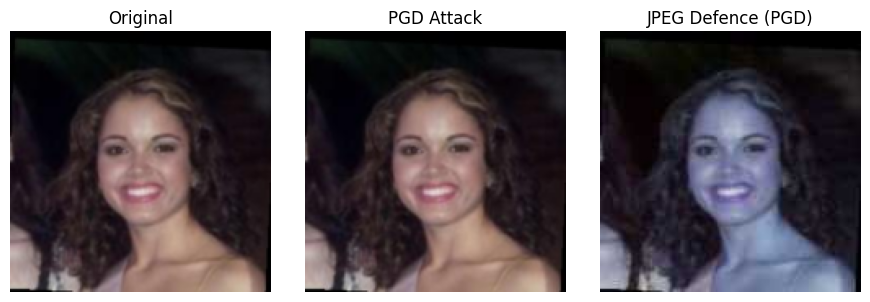

In [10]:
# --------------------------------------------------------------
# Step 9: PGD demonstration (single sample)
# --------------------------------------------------------------
img, lbl = next(iter(lfw_loader))
img = img.to(device)

# Run PGD attack on a single image
pgd = pgd_attack(model, img, eps=0.1, alpha=0.01, steps=20)

# Compare similarities
sim_pgd = cos(model(img), model(pgd)).item()
print("\nPGD cosine sim:", sim_pgd)

# Run JPEG defence
jpeg_pgd = jpeg_defence(pgd)
sim_jpeg = cos(model(img), model(jpeg_pgd)).item()
print("PGD + JPEG cosine sim:", sim_jpeg)

# Run Blur defence
blur_pgd = blur_defence(pgd)
sim_blur = cos(model(img), model(blur_pgd)).item()
print("PGD + Blur defence cosine sim:", sim_blur)

# Visualise
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); show(img); plt.title("Original")
plt.subplot(1,3,2); show(pgd); plt.title("PGD Attack")
plt.subplot(1,3,3); show(jpeg_pgd); plt.title("JPEG Defence (PGD)")
plt.tight_layout()
plt.show()


In [11]:
# --------------------------------------------------------------
# Step 10: PGD Benchmark Loop (JPEG + Blur Defence)
# --------------------------------------------------------------
epsilons = [0.05, 0.1, 0.15, 0.3]
sim_threshold = 0.8  # Below this = successful attack
recov_threshold = 0.9  # Above this = successful defence

print("\nPGD Benchmark Across Epsilons")

for eps in epsilons:
    attack_success = 0
    jpeg_recovery = 0
    blur_recovery = 0
    total = 0

    for _ in range(30):
        img, lbl = next(iter(lfw_loader))
        img = img.to(device)
        
        # Generate PGD adversarial
        adv = pgd_attack(model, img, eps=eps, alpha=0.01, steps=20)

        # Evaluate attack success
        sim_adv = cos(model(img), model(adv)).item()
        if sim_adv < sim_threshold:
            attack_success += 1

        # JPEG defence
        jpeg = jpeg_defence(adv)
        sim_jpeg = cos(model(img), model(jpeg)).item()
        if sim_jpeg > recov_threshold:
            jpeg_recovery += 1

        # Blur defence
        blur = blur_defence(adv)
        sim_blur = cos(model(img), model(blur)).item()
        if sim_blur > recov_threshold:
            blur_recovery += 1

        total += 1

    print(f"Epsilon {eps:.2f} | PGD Attack Success: {attack_success/total:.2f} | JPEG Recovery: {jpeg_recovery/total:.2f} | Blur Recovery: {blur_recovery/total:.2f}")



PGD Benchmark Across Epsilons
Epsilon 0.05 | PGD Attack Success: 0.00 | JPEG Recovery: 0.83 | Blur Recovery: 0.43
Epsilon 0.10 | PGD Attack Success: 0.00 | JPEG Recovery: 0.87 | Blur Recovery: 0.50
Epsilon 0.15 | PGD Attack Success: 0.00 | JPEG Recovery: 0.73 | Blur Recovery: 0.40
Epsilon 0.30 | PGD Attack Success: 0.00 | JPEG Recovery: 0.77 | Blur Recovery: 0.50
